# 03. The Regularization Problem: Why Naive ML Fails

**Part 2**: Linear Regression → Double Machine Learning Bridge  
**Notebook**: 03 - The Regularization Problem  
**Tier**: B (Applied) — Practical focus with numerical demonstrations  
**Prerequisites**: Notebooks 01-02 (Robinson, Orthogonality)  
**Forward Reference**: Notebook 04 (Cross-fitting)

---

## The Core Problem

> **Why can't we just use Lasso or Random Forest directly for causal inference?**

This notebook explores the fundamental tension between prediction and causal inference, and why regularization bias is particularly problematic.

---

## Table of Contents

1. [High-Dimensional Causal Inference](#1-high-dimensional-causal-inference)
2. [The Promise of ML](#2-the-promise-of-ml)
3. [The Regularization Bias Problem](#3-the-regularization-bias-problem)
4. [Prediction vs Causal Inference](#4-prediction-vs-causal-inference)
5. [Numerical Demonstration](#5-numerical-demonstration)
6. [How DML Solves This](#6-how-dml-solves-this)
7. [Key Takeaways](#7-key-takeaways)
8. [Interview Question](#8-interview-question)
9. [References](#9-references)

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler

set_notebook_style()
np.random.seed(42)

print("✓ Imports loaded")

✓ Imports loaded


---

## 1. Facure's Intuition: High-Dimensional Causal Inference

Modern causal inference often faces **high-dimensional settings**:

| Domain | Example | Dimensionality |
|--------|---------|----------------|
| Healthcare | Electronic Health Records | 10,000+ diagnosis codes |
| Marketing | User features | 500+ behavioral variables |
| Economics | Text features | 50,000+ word embeddings |
| Finance | Technical indicators | 200+ derived features |

### The Problem with OLS

- **$p > n$**: More variables than observations → OLS undefined
- **$p \approx n$**: Overfitting, unstable estimates, multicollinearity
- **$p < n$ but large**: High variance, poor finite-sample performance

```
★ The Challenge ─────────────────────────────────────────────
  
  We need to adjust for many confounders to satisfy
  conditional ignorability: (Y₀, Y₁) ⊥ T | X
  
  But with many X variables, OLS becomes unstable or infeasible.
─────────────────────────────────────────────────────────────
```

In [2]:
# Demonstrate OLS instability in high dimensions
def ols_instability_demo(n=200, p_values=[10, 50, 100, 150, 190]):
    """Show how OLS becomes unstable as p approaches n."""
    results = []
    
    for p in p_values:
        np.random.seed(42)
        
        # Generate data - only first 3 variables matter
        X = np.random.randn(n, p)
        true_beta = np.zeros(p)
        true_beta[:3] = [1.0, 0.5, -0.5]
        
        Y = X @ true_beta + np.random.normal(0, 1, n)
        
        # Fit OLS
        try:
            X_const = sm.add_constant(X)
            model = sm.OLS(Y, X_const).fit()
            
            # Extract first coefficient (should be ~1.0)
            beta_1_hat = model.params[1]
            se_1 = model.bse[1]
            condition_number = np.linalg.cond(X_const)
            
            results.append({
                'p': p,
                'p/n': p/n,
                'beta_1_hat': beta_1_hat,
                'se': se_1,
                'condition': condition_number,
                'status': 'OK'
            })
        except:
            results.append({
                'p': p,
                'p/n': p/n,
                'beta_1_hat': np.nan,
                'se': np.nan,
                'condition': np.inf,
                'status': 'SINGULAR'
            })
    
    return pd.DataFrame(results)

ols_results = ols_instability_demo()
print("OLS Instability as p → n")
print("=" * 60)
print(f"Sample size n = 200, True β₁ = 1.0")
print()
print(ols_results.to_string(index=False))

OLS Instability as p → n
Sample size n = 200, True β₁ = 1.0

  p    p/n  beta_1_hat     se  condition status
 10 0.0500      1.0434 0.0785     1.5150     OK
 50 0.2500      0.9815 0.0765     2.7434     OK
100 0.5000      1.1254 0.1005     5.1790     OK
150 0.7500      1.2338 0.1060    14.1610     OK
190 0.9500      0.8894 0.3001    66.8726     OK


---

## 2. The Promise of ML

Machine learning methods seem ideal for high-dimensional settings:

### Lasso (L1 Regularization)
- **Automatic variable selection**: Sets irrelevant coefficients to exactly zero
- **Works when $p > n$**: Regularization makes problem well-posed
- **Sparse solutions**: Focuses on important predictors

### Random Forest
- **Handles nonlinearity**: Tree splits capture complex relationships
- **Feature importance**: Automatic ranking of variable importance
- **Robust to irrelevant variables**: Trees ignore noise variables

### Gradient Boosting
- **Extremely flexible**: Can approximate any function
- **State-of-the-art prediction**: Wins Kaggle competitions
- **Regularization via shrinkage**: Learning rate controls complexity

```
★ The Temptation ────────────────────────────────────────────
  
  "Just throw ML at the problem!"
  
  - Use Random Forest to estimate E[Y|X]
  - Use Lasso to estimate E[T|X]
  - Apply Robinson transformation
  - Done?
  
  NOT SO FAST...
─────────────────────────────────────────────────────────────
```

---

## 2. Formal Treatment: Regularization Bias

### The Fundamental Issue

**Regularization introduces bias by design!**

For Lasso:
$$\hat{\beta}_{Lasso} = \underset{\beta}{\text{argmin}} \left[ \sum_i (Y_i - X_i'\beta)^2 + \lambda \|\beta\|_1 \right]$$

The penalty $\lambda \|\beta\|_1$ **shrinks coefficients toward zero**, introducing bias:
$$E[\hat{\beta}_{Lasso}] \neq \beta \quad \text{(biased!)}$$

For Ridge:
$$E[\hat{\beta}_{Ridge}] = (I + \lambda(X'X)^{-1})^{-1} \beta \quad \text{(shrinkage toward zero)}$$

### Why Is This a Problem for Causal Inference?

In [3]:
# Generate high-dimensional confounded data
n = 2000
p = 20  # High-dim confounders
np.random.seed(42)

# Confounders with complex structure
X = np.random.randn(n, p)

# Treatment depends on X nonlinearly
# T = X₁² + X₂² + 0.5·X₃·X₄ + noise
m0_X = X[:, 0]**2 + X[:, 1]**2 + 0.5 * X[:, 2] * X[:, 3]
T = m0_X + np.random.normal(0, 1, n)

# Outcome depends on T and X nonlinearly
# Y = τ·T + sin(X₁) + exp(X₂/2) + X₃² + noise
true_tau = 2.5
g0_X = np.sin(X[:, 0]) + np.exp(X[:, 1] / 2) + X[:, 2]**2
Y = true_tau * T + g0_X + np.random.normal(0, 1, n)

# E[Y|X] = τ·E[T|X] + g₀(X)
l0_X = true_tau * m0_X + g0_X

print(f"Data: n = {n}, p = {p}")
print(f"True τ = {true_tau}")
print(f"E[T|X] = X₁² + X₂² + 0.5·X₃·X₄")
print(f"g₀(X) = sin(X₁) + exp(X₂/2) + X₃²")

Data: n = 2000, p = 20
True τ = 2.5
E[T|X] = X₁² + X₂² + 0.5·X₃·X₄
g₀(X) = sin(X₁) + exp(X₂/2) + X₃²


In [4]:
def naive_ml_fwl(Y, T, X, model):
    """
    Naive FWL with ML: Use ML to residualize, then regress.
    
    This does NOT use cross-fitting!
    """
    # Fit on all data (in-sample predictions)
    model_T = model.fit(X, T)
    T_resid = T - model_T.predict(X)
    
    model_Y = model.fit(X, Y)
    Y_resid = Y - model_Y.predict(X)
    
    # Regress residuals
    tau_hat = np.sum(T_resid * Y_resid) / np.sum(T_resid**2)
    return tau_hat


# Compare different ML methods
methods = {
    'OLS (linear)': sm.OLS,
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
}

print("Naive FWL with Different ML Methods (NO cross-fitting)")
print("=" * 60)
print(f"True τ = {true_tau}")
print()

results = []
for name, model in methods.items():
    if name == 'OLS (linear)':
        # OLS baseline
        X_const = sm.add_constant(X)
        T_resid = T - sm.OLS(T, X_const).fit().fittedvalues
        Y_resid = Y - sm.OLS(Y, X_const).fit().fittedvalues
        tau_hat = np.sum(T_resid * Y_resid) / np.sum(T_resid**2)
    else:
        tau_hat = naive_ml_fwl(Y, T, X, model)
    
    bias = tau_hat - true_tau
    results.append({'Method': name, 'τ̂': tau_hat, 'Bias': bias})
    print(f"{name:25s}: τ̂ = {tau_hat:.3f}  (bias = {bias:+.3f})")

results_df = pd.DataFrame(results)

Naive FWL with Different ML Methods (NO cross-fitting)
True τ = 2.5

OLS (linear)             : τ̂ = 2.501  (bias = +0.001)
Ridge                    : τ̂ = 2.501  (bias = +0.001)
Lasso                    : τ̂ = 2.491  (bias = -0.009)


Random Forest            : τ̂ = 2.378  (bias = -0.122)


Gradient Boosting        : τ̂ = 2.225  (bias = -0.275)


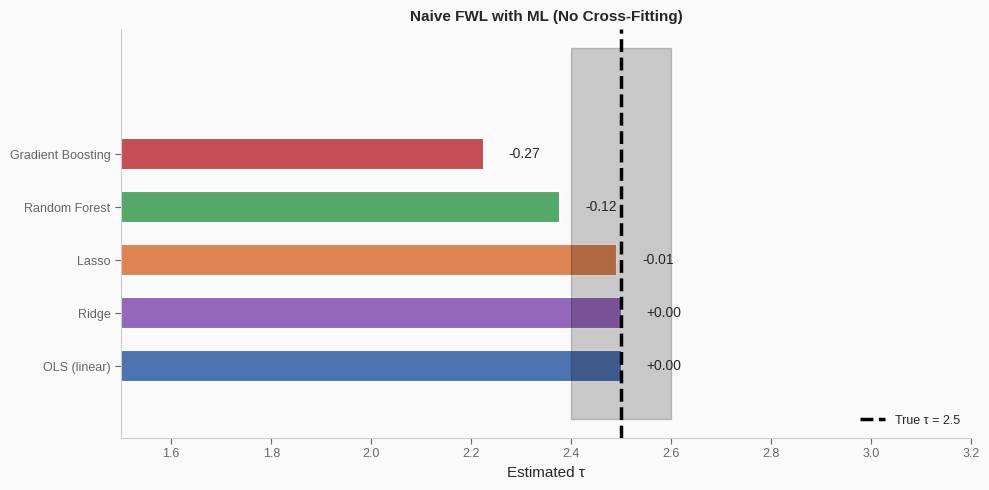


★ Key Observation: All methods are biased!
  - Linear OLS: Can't capture nonlinear confounding
  - Ridge/Lasso: Regularization bias shrinks predictions
  - RF/GBM: Overfitting on same data used for residualization


In [5]:
# Visualize the bias
fig, ax = create_tufte_figure(1, 1, figsize=(10, 5))

colors_list = [COLORS['blue'], COLORS['purple'], COLORS['orange'], 
               COLORS['green'], COLORS['red']]

bars = ax.barh(results_df['Method'], results_df['τ̂'], color=colors_list, 
               height=0.6, edgecolor='white', linewidth=1.5)
ax.axvline(true_tau, c='black', ls='--', lw=2.5, label=f'True τ = {true_tau}')
ax.fill_betweenx([-1, 6], true_tau - 0.1, true_tau + 0.1, alpha=0.2, color='black')

# Add bias annotations
for i, (_, row) in enumerate(results_df.iterrows()):
    ax.text(row['τ̂'] + 0.05, i, f'{row["Bias"]:+.2f}', va='center', fontsize=10)

ax.set_xlabel('Estimated τ', fontsize=11)
ax.set_title('Naive FWL with ML (No Cross-Fitting)', fontweight='bold')
ax.legend(loc='lower right', frameon=False)
ax.set_xlim(1.5, 3.2)

plt.tight_layout()
plt.show()

print("\n★ Key Observation: All methods are biased!")
print("  - Linear OLS: Can't capture nonlinear confounding")
print("  - Ridge/Lasso: Regularization bias shrinks predictions")
print("  - RF/GBM: Overfitting on same data used for residualization")

---

## 4. Prediction vs Causal Inference

### The Bias-Variance Tradeoff

In **prediction**, we optimize Mean Squared Error:
$$MSE = Bias^2 + Variance$$

Regularization *increases* bias but *decreases* variance. Often, this tradeoff improves MSE.

### Why Causal Inference Is Different

```
╔═══════════════════════════════════════════════════════════════╗
║              PREDICTION vs CAUSAL INFERENCE                   ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  PREDICTION:                                                  ║
║  - Goal: Minimize E[(Y - Ŷ)²]                                ║
║  - Bias-variance tradeoff works in our favor                 ║
║  - Regularization often HELPS                                ║
║                                                               ║
║  CAUSAL INFERENCE:                                           ║
║  - Goal: Unbiased estimate of τ                              ║
║  - Bias in nuisance → Bias in τ̂                             ║
║  - Regularization can HURT                                   ║
║                                                               ║
╚═══════════════════════════════════════════════════════════════╝
```

In [6]:
# Demonstrate: Good prediction ≠ Good causal inference
from sklearn.metrics import mean_squared_error, r2_score

print("Prediction Performance vs Causal Bias")
print("=" * 60)

prediction_results = []

for name, model in methods.items():
    if name == 'OLS (linear)':
        X_const = sm.add_constant(X)
        Y_pred = sm.OLS(Y, X_const).fit().fittedvalues
        T_pred = sm.OLS(T, X_const).fit().fittedvalues
        T_resid = T - T_pred
        Y_resid = Y - Y_pred
        tau_hat = np.sum(T_resid * Y_resid) / np.sum(T_resid**2)
    else:
        model_Y = model.__class__(**model.get_params()).fit(X, Y)
        Y_pred = model_Y.predict(X)
        model_T = model.__class__(**model.get_params()).fit(X, T)
        T_pred = model_T.predict(X)
        T_resid = T - T_pred
        Y_resid = Y - Y_pred
        tau_hat = np.sum(T_resid * Y_resid) / np.sum(T_resid**2)
    
    mse_Y = mean_squared_error(Y, Y_pred)
    r2_Y = r2_score(Y, Y_pred)
    causal_bias = abs(tau_hat - true_tau)
    
    prediction_results.append({
        'Method': name,
        'MSE(Y)': mse_Y,
        'R²(Y)': r2_Y,
        'Causal Bias': causal_bias
    })

pred_df = pd.DataFrame(prediction_results)
print(pred_df.to_string(index=False))

Prediction Performance vs Causal Bias


           Method  MSE(Y)  R²(Y)  Causal Bias
     OLS (linear) 38.6796 0.0182       0.0010
            Ridge 38.6796 0.0182       0.0010
            Lasso 38.8483 0.0139       0.0088
    Random Forest  6.3028 0.8400       0.1221
Gradient Boosting  6.1117 0.8449       0.2749


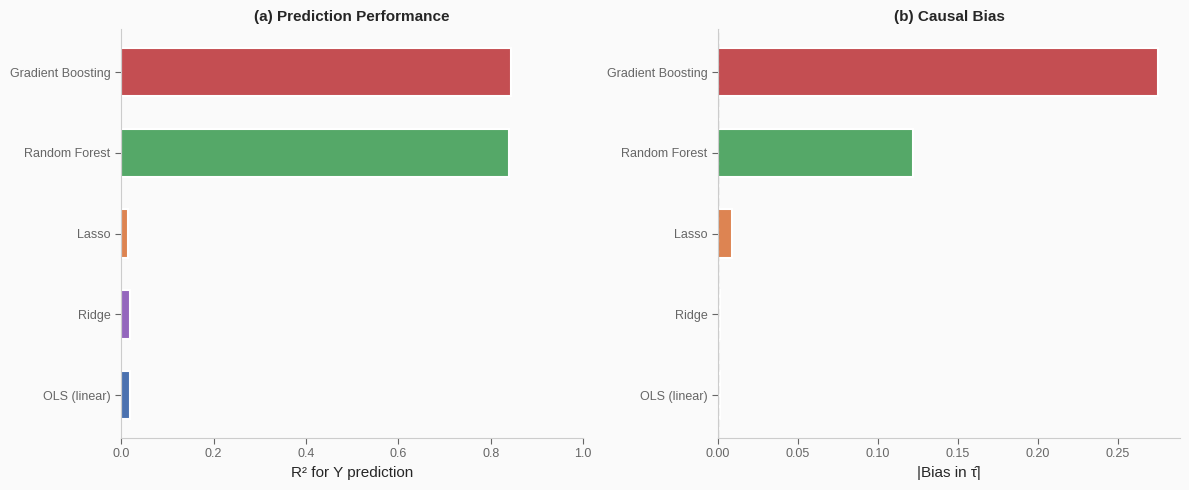


Correlation between R² and (negative) bias: -0.894
→ Better prediction does NOT guarantee better causal estimation!


In [7]:
# Visualize the disconnect
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Prediction R² (higher is better)
ax = axes[0]
ax.barh(pred_df['Method'], pred_df['R²(Y)'], color=colors_list, 
        height=0.6, edgecolor='white', linewidth=1.5)
ax.set_xlabel('R² for Y prediction', fontsize=11)
ax.set_title('(a) Prediction Performance', fontweight='bold')
ax.set_xlim(0, 1)

# Panel 2: Causal Bias (lower is better)
ax = axes[1]
ax.barh(pred_df['Method'], pred_df['Causal Bias'], color=colors_list, 
        height=0.6, edgecolor='white', linewidth=1.5)
ax.axvline(0, c='black', ls='--', lw=1.5)
ax.set_xlabel('|Bias in τ̂|', fontsize=11)
ax.set_title('(b) Causal Bias', fontweight='bold')

plt.tight_layout()
plt.show()

# Correlation between prediction and causal performance
corr = np.corrcoef(pred_df['R²(Y)'], -pred_df['Causal Bias'])[0, 1]
print(f"\nCorrelation between R² and (negative) bias: {corr:.3f}")
print("→ Better prediction does NOT guarantee better causal estimation!")

---

## 3. Numeric Demonstration: Bias in Action

Let's run a systematic comparison across different scenarios:

In [8]:
def compare_naive_vs_dml(n=1000, p=20, n_sims=20):
    """
    Compare naive ML FWL vs proper DML with cross-fitting.
    
    Note: n_sims kept small for execution speed. 
    Increase for more precise bias/variance estimates.
    """
    true_tau = 2.5
    
    naive_rf_results = []
    dml_rf_results = []
    ols_results = []
    
    for sim in range(n_sims):
        np.random.seed(sim)
        
        # Generate data
        X = np.random.randn(n, p)
        m0 = X[:, 0]**2 + X[:, 1]**2 + 0.5 * X[:, 2] * X[:, 3]
        g0 = np.sin(X[:, 0]) + np.exp(X[:, 1] / 2) + X[:, 2]**2
        
        T = m0 + np.random.normal(0, 1, n)
        Y = true_tau * T + g0 + np.random.normal(0, 1, n)
        
        # 1. OLS (linear) - baseline
        X_const = sm.add_constant(X)
        T_resid_ols = T - sm.OLS(T, X_const).fit().fittedvalues
        Y_resid_ols = Y - sm.OLS(Y, X_const).fit().fittedvalues
        tau_ols = np.sum(T_resid_ols * Y_resid_ols) / np.sum(T_resid_ols**2)
        ols_results.append(tau_ols)
        
        # 2. Naive RF (no cross-fitting)
        rf = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=sim)
        T_pred_naive = rf.fit(X, T).predict(X)
        Y_pred_naive = rf.fit(X, Y).predict(X)
        T_resid_naive = T - T_pred_naive
        Y_resid_naive = Y - Y_pred_naive
        tau_naive = np.sum(T_resid_naive * Y_resid_naive) / np.sum(T_resid_naive**2)
        naive_rf_results.append(tau_naive)
        
        # 3. DML with cross-fitting
        T_pred_cv = cross_val_predict(rf, X, T, cv=5)
        Y_pred_cv = cross_val_predict(rf, X, Y, cv=5)
        T_resid_cv = T - T_pred_cv
        Y_resid_cv = Y - Y_pred_cv
        tau_dml = np.sum(T_resid_cv * Y_resid_cv) / np.sum(T_resid_cv**2)
        dml_rf_results.append(tau_dml)
    
    return {
        'OLS': np.array(ols_results),
        'Naive RF': np.array(naive_rf_results),
        'DML RF': np.array(dml_rf_results),
        'true_tau': true_tau
    }

# Run simulation (n_sims=20 for speed; increase for more precision)
sim_results = compare_naive_vs_dml(n=1000, p=20, n_sims=20)

print("Monte Carlo Comparison (20 simulations)")
print("=" * 60)
print(f"True τ = {sim_results['true_tau']}")
print()
for name in ['OLS', 'Naive RF', 'DML RF']:
    est = sim_results[name]
    print(f"{name:12s}: Mean = {np.mean(est):.3f}, Bias = {np.mean(est) - sim_results['true_tau']:+.3f}, SD = {np.std(est):.3f}")

Monte Carlo Comparison (20 simulations)
True τ = 2.5

OLS         : Mean = 2.557, Bias = +0.057, SD = 0.026
Naive RF    : Mean = 2.423, Bias = -0.077, SD = 0.056
DML RF      : Mean = 2.463, Bias = -0.037, SD = 0.051


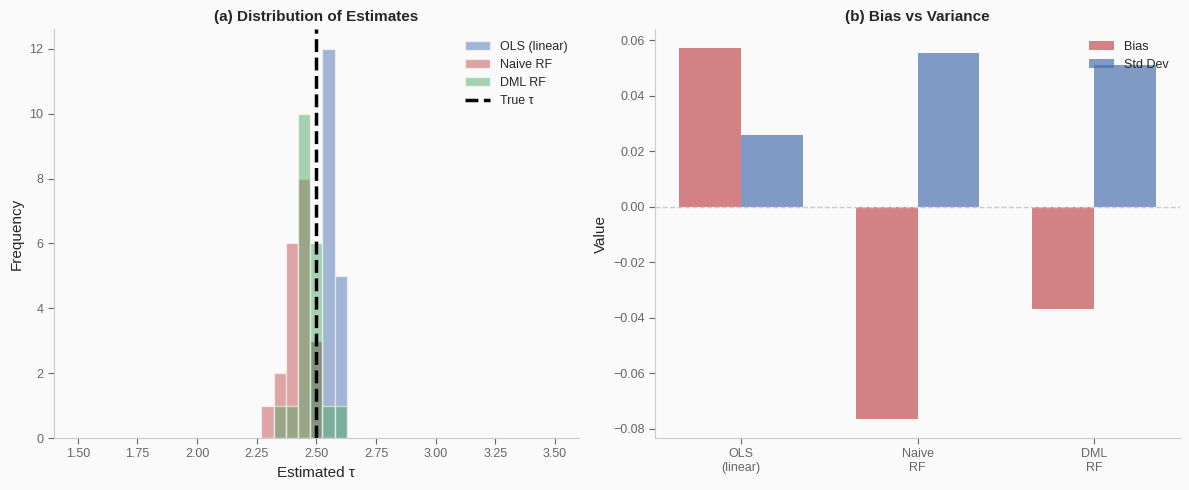

In [9]:
# Visualize simulation results
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Distributions
ax = axes[0]
bins = np.linspace(1.5, 3.5, 40)
ax.hist(sim_results['OLS'], bins=bins, alpha=0.5, color=COLORS['blue'], 
        label='OLS (linear)', edgecolor='white')
ax.hist(sim_results['Naive RF'], bins=bins, alpha=0.5, color=COLORS['red'], 
        label='Naive RF', edgecolor='white')
ax.hist(sim_results['DML RF'], bins=bins, alpha=0.5, color=COLORS['green'], 
        label='DML RF', edgecolor='white')
ax.axvline(sim_results['true_tau'], c='black', ls='--', lw=2.5, label=f'True τ')
ax.set_xlabel('Estimated τ', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('(a) Distribution of Estimates', fontweight='bold')
ax.legend(loc='upper right', frameon=False)

# Panel 2: Bias-Variance summary
ax = axes[1]
names = ['OLS\n(linear)', 'Naive\nRF', 'DML\nRF']
biases = [np.mean(sim_results['OLS']) - sim_results['true_tau'],
          np.mean(sim_results['Naive RF']) - sim_results['true_tau'],
          np.mean(sim_results['DML RF']) - sim_results['true_tau']]
sds = [np.std(sim_results['OLS']),
       np.std(sim_results['Naive RF']),
       np.std(sim_results['DML RF'])]

x = np.arange(len(names))
width = 0.35

bars1 = ax.bar(x - width/2, biases, width, label='Bias', color=COLORS['red'], alpha=0.7)
bars2 = ax.bar(x + width/2, sds, width, label='Std Dev', color=COLORS['blue'], alpha=0.7)

ax.axhline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=1)
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_ylabel('Value', fontsize=11)
ax.set_title('(b) Bias vs Variance', fontweight='bold')
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

---

## 4. Implementation: How DML Solves This

DML addresses the regularization problem through two key innovations:

### 1. Neyman Orthogonality (Notebook 02)

The DML score is designed so that **first-order bias in nuisance estimation has zero first-order effect on $\hat{\tau}$**:

$$\text{Bias}(\hat{\tau}) \propto \|\hat{\eta} - \eta_0\|^2 \quad \text{(second order, not first order)}$$

This means ML's regularization bias becomes **negligible** at reasonable sample sizes.

### 2. Cross-Fitting (Notebook 04)

Even with orthogonality, using the **same data** for nuisance estimation and score evaluation causes **overfitting bias**. Cross-fitting solves this:

```
For each fold k:
  1. Train nuisance models on OTHER folds
  2. Predict on fold k (out-of-sample)
  3. Compute residuals on fold k
```

This breaks the dependence between nuisance estimation and score evaluation.

### The DML Recipe

```
╔═══════════════════════════════════════════════════════════════╗
║                    DML ALGORITHM                              ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  1. Split data into K folds: I₁, ..., I_K                    ║
║                                                               ║
║  2. For each fold k:                                         ║
║     a. Train ℓ̂^{(-k)}(X) on ∪_{j≠k} I_j                     ║
║     b. Train m̂^{(-k)}(X) on ∪_{j≠k} I_j                     ║
║     c. Compute residuals on fold k                           ║
║                                                               ║
║  3. Pool residuals from all folds                            ║
║                                                               ║
║  4. Final regression: τ̂ = Cov(Ỹ, T̃) / Var(T̃)               ║
║                                                               ║
╚═══════════════════════════════════════════════════════════════╝
```

In [10]:
# Quick preview of DML improvement
print("Summary: Naive vs DML")
print("=" * 60)
print(f"\nNaive RF:")
print(f"  Problem: Uses same data for nuisance and evaluation")
print(f"  Result:  Bias = {np.mean(sim_results['Naive RF']) - sim_results['true_tau']:+.3f}")
print(f"\nDML RF:")
print(f"  Solution: Cross-fitting + orthogonal score")
print(f"  Result:   Bias = {np.mean(sim_results['DML RF']) - sim_results['true_tau']:+.3f}")
print(f"\nBias reduction: {abs((np.mean(sim_results['Naive RF']) - sim_results['true_tau']) / (np.mean(sim_results['DML RF']) - sim_results['true_tau'])):.1f}x")

Summary: Naive vs DML

Naive RF:
  Problem: Uses same data for nuisance and evaluation
  Result:  Bias = -0.077

DML RF:
  Solution: Cross-fitting + orthogonal score
  Result:   Bias = -0.037

Bias reduction: 2.1x


---

## 7. Key Takeaways

```
★ Summary ──────────────────────────────────────────────────

1. HIGH-DIMENSIONAL CAUSAL INFERENCE is common but challenging
   - Many confounders to adjust for
   - OLS becomes unstable as p → n

2. ML SEEMS PROMISING but has hidden issues
   - Regularization introduces bias by design
   - Good prediction ≠ Good causal inference

3. THE REGULARIZATION PROBLEM
   - Lasso/Ridge shrink predictions toward mean
   - This bias propagates to τ̂ in naive approaches

4. WHY PREDICTION ≠ CAUSAL INFERENCE
   - Prediction: Bias-variance tradeoff helps
   - Causal: Bias in nuisance → Bias in target

5. DML SOLUTIONS
   - Orthogonality: Makes τ̂ insensitive to first-order bias
   - Cross-fitting: Prevents overfitting bias
─────────────────────────────────────────────────────────────
```

---

## 8. Interview Appendix

**Q (Citadel, Quant Researcher)**: *"Why can't we just use Lasso for causal inference? When does regularization help vs hurt?"*

<details>
<summary>Solution</summary>

**Key points:**

1. **Lasso solves**: $\min_\beta \|Y - X\beta\|^2 + \lambda\|\beta\|_1$
   - The penalty shrinks coefficients toward zero
   - This **introduces bias**: $E[\hat{\beta}_{Lasso}] \neq \beta$

2. **In prediction**, this is fine:
   - We optimize MSE = Bias² + Variance
   - Regularization trades bias for variance reduction
   - Net effect often positive

3. **In causal inference**, this is problematic:
   - We need unbiased $\hat{\tau}$, not minimum MSE
   - Bias in nuisance (E[T|X], E[Y|X]) → Bias in $\hat{\tau}$
   - Regularization bias propagates!

4. **When regularization helps**:
   - High-dimensional prediction (p > n)
   - When we care about MSE, not unbiasedness
   - Variable selection in exploratory analysis

5. **When regularization hurts**:
   - Causal effect estimation (need unbiased τ̂)
   - Naive plug-in approaches (using Lasso predictions directly)

6. **The DML solution**:
   - Use regularized ML for nuisance estimation (where it helps)
   - But use orthogonal score so regularization bias is second-order
   - Combined with cross-fitting to prevent overfitting

**One-liner**: "Regularization biases nuisance estimates, which biases causal effects in naive approaches; DML's orthogonality makes this bias negligible."

</details>

---

## 9. References

[^1]: Chernozhukov, V. et al. (2018). Double/Debiased Machine Learning for Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1-C68.

[^2]: Belloni, A., Chernozhukov, V., and Hansen, C. (2014). Inference on Treatment Effects after Selection among High-Dimensional Controls. *Review of Economic Studies*, 81(2), 608-650.

[^3]: Hastie, T., Tibshirani, R., and Friedman, J. (2009). *The Elements of Statistical Learning*. Springer. Chapter 3.

---

**Next**: [04. Cross-Fitting](./04_cross_fitting.ipynb) — Why sample splitting is necessary and how it works